In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as ani
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def two_body_house_solution(thernal_floor, thermal_internal_walls, thermal_external_walls,Te_const,Te_sin_coef,Tg,T0,f):
    num_rooms = len(thermal_internal_walls)

    K = []
    for i in range(num_rooms):
        row = []
        for j in range(num_rooms):
            if i == j:
                row.append(-thernal_floor[i] - thermal_external_walls[i] - sum(thermal_internal_walls[i]))
            else:
                row.append(thermal_internal_walls[i][j])
        K.append(row)
  
    K = np.array(K)

    EigVals, EigVectors = np.linalg.eig(K)
    temp = EigVectors[:,0] / np.abs(EigVectors[0,0])
    EigVectors = np.array([ EigVectors[:,i] / np.abs(EigVectors[0,i]) for i in range(num_rooms) ])
  
    firstSolution = lambda t,c: np.sum([ c[i]*np.exp(EigVals[i])*EigVectors[i] for i in range(num_rooms) ])

    A_matrix = []
    b_matrix = []

    for i in range(num_rooms):
        Si = np.zeros(num_rooms*3)
        Co = np.zeros(num_rooms*3)
        Con = np.zeros(num_rooms*3)
    
        Si[i+num_rooms] += -np.pi/12
        Co[i] += np.pi/12

        for j in range(num_rooms):
            Si[j] -= K[i][j]
            Co[j+num_rooms] -= K[i][j]
            Con[j+num_rooms*2] -= K[i][j]

        a = thermal_external_walls[i] * Te_sin_coef
        b = 0
        d = thernal_floor[i]*Tg + thermal_external_walls[i] * Te_const

        A_matrix += [Si,Co,Con]
        b_matrix += [a,b,d]

    A_matrix = np.array(A_matrix)
    b_matrix = np.array(b_matrix)
    coeff = np.linalg.solve(A_matrix, b_matrix)
    secondSolution = lambda t: np.array([ coeff[i]*np.sin(np.pi/12*t) + coeff[i+num_rooms]*np.cos(np.pi/12*t) + coeff[i+num_rooms*2] for i in range(num_rooms) ])

    coeff2 = np.linalg.solve(K, -np.array(f))
    thirdSolution = lambda t: coeff2

    collected_solution = lambda t,c: firstSolution(t,c) + secondSolution(t) + thirdSolution(t)

    c0 = np.zeros(num_rooms)
    initial_point = collected_solution(0, c0)
    C = EigVectors.T
    real_C = np.linalg.solve(C, T0 - initial_point)
    final_solution = lambda t: np.array([collected_solution(sub_t, real_C) for sub_t in t])
    return final_solution


# Heat Diffusion through a solid medium
### 2-dimensional heat Equation
We wish to solve the equation
> $u_t = k(u_{xx} + u_{yy})$

With dirichlet boundary conditions:
> $u(0,x,0) = u(0,x,a) = f(x)$, 
>
>$u(0,0,y) = u(0,b,y) = g(y)$

Using the explicit centered finite difference scheme:

> $u_{i,j}^{k+1} - k(\frac{u^{k}_{i+1,j} - 2u^k_{i,j} + u^k_{i-1,j}}{\Delta x^2} + \frac{u^{k}_{i,j+1} - 2u^k_{i,j} + u^k_{i,j-1}}{\Delta y^2}) = 0$

Which we can rewrite as follows, if we assume $\Delta x = \Delta y$:

>  $u_{i,j}^{k+1} = \gamma(u^{k}_{i+1,j} + u^k_{i-1,j} + u^k_{i,j+1}+ u^k_{i,j-1} - 4u^k_{i,j}) + u^k_{i,j}$

where

> $\gamma =  k \frac{\Delta t}{\Delta x^2}$

This is stable under the CFL Conditions

> $\Delta t \leq \frac{\Delta x^2}{4k}$

In [3]:
plate_length = 50
max_iter_time = 1000

alpha = 4.2 # thermal diffusivity constant of materials
delta_x = 1

delta_t = (delta_x **2) / (4*alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

u = np.empty((max_iter_time, plate_length, plate_length))
# initial conditions
u_initial = 75

u_top = 54
u_left = 70
u_bottom = 70
u_right = 70

u.fill(u_initial)

u[:,(plate_length-1):,:] = u_top
u[:,:,:1] = u_left
u[:,:1,1:] = u_bottom
u[:,:,(plate_length-1):] = u_right
print(u[0,:1,1:])

[[70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70.
  70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70.
  70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70. 70.]]


In [4]:
def finite_difference(u):
    for k in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k+1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
    return u

In [5]:
def plot(k, min, max):
    plt.clf()
    plt.title(f'Temperature at t = {k*delta_t:.3f} time')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.pcolormesh(u[k], cmap=plt.cm.jet, vmin=min, vmax=max)
    plt.colorbar()
    
    
    return plt

In [6]:
plt.ioff()
def update(i):
    plotheatmap(u[i], i)
    
u = finite_difference(u)
anim = ani.FuncAnimation(plt.figure(), plot, interval=2, frames=max_iter_time, repeat=False, fargs=(0,100))

HTML(anim.to_html5_video())

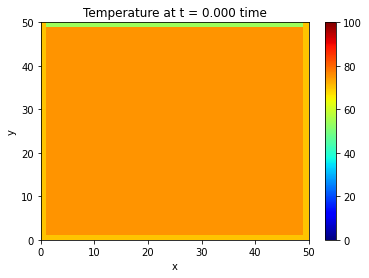

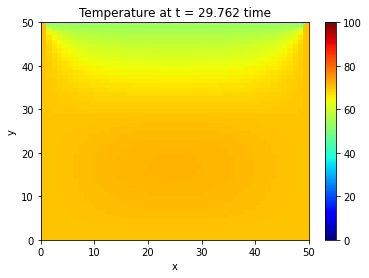

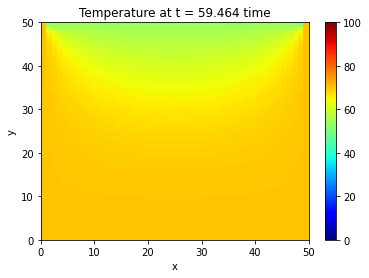

In [7]:
plot(0, 0, 100)
plt.show()
plot(max_iter_time // 2, 0, 100)
plt.show()
plot(max_iter_time-1, 0, 100)
plt.show()

### Variable boundary conditions

Constant boundary conditions may not be ideal for what we are trying to represent, so we need a method of varying boundary conditions.

In [8]:
def finite_difference_var(u, b_top, b_left, b_right, b_bottom):
    for k in range(0, max_iter_time-1, 1):
        if k > 0:
            u[k+1,(plate_length-1):,:] = b_top[k]
            u[k+1,:,:1] = b_left[k]
            u[k+1,:1,1:] = b_bottom[k]
            u[k+1,:,(plate_length-1):] = b_right[k] 
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k+1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
    return u

In [9]:
k1 = 1/10
k2 = 1/5
k3 = 2/5
k4 = 1/2
thermal_floor = [k1, 0, 1/10]

thermal_internal_walls = [[0,k2, k2], [k2,0, 0], [k2, 0, 0]]

thermal_external_walls = [k3, k4, k3]

Tg = 10

Te_const = 10
Te_sin_coef = 10

T0 = [10,5, 10]

f = [5, 0, 0]

T = two_body_house_solution(thermal_floor, thermal_internal_walls, thermal_external_walls,Te_const,Te_sin_coef,Tg,T0,f)

Tg = lambda t: Te_const + Te_sin_coef*np.sin(np.pi/12*t) 
plate_length = 100
max_iter_time = 2000

alpha = 30 # thermal diffusivity constant of material
delta_x = 1

delta_t = (delta_x **2) / (4*alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)
times = np.linspace(0, delta_t * max_iter_time, max_iter_time)

boundaries = T(times)
b_top = boundaries[:,0]
b_left = boundaries[:,1]
b_right = boundaries[:,2]

b_bottom = Tg(times)

u = np.empty((max_iter_time, plate_length, plate_length))
# initial conditions
u_initial = (b_top[0] + b_left[0] + b_right[0] + b_bottom[0]) / 4

u.fill(u_initial)

u[:,(plate_length-1):,:] = b_top[0]
u[:,:,:1] = b_left[0]
u[:,:1,1:] = b_bottom[0]
u[:,:,(plate_length-1):] = b_right[0]



plt.ioff()
u = finite_difference_var(u, b_top, b_left, b_right, b_bottom)
anim = ani.FuncAnimation(plt.figure(), plot, interval=2, frames=max_iter_time, repeat=False, fargs=(np.amin(u), np.amax(u) + 10))

HTML(anim.to_html5_video())

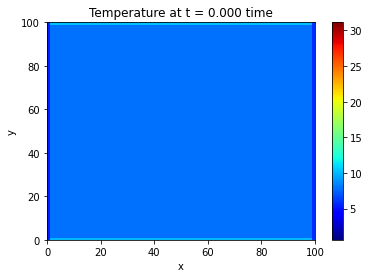

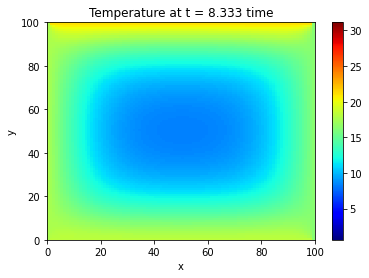

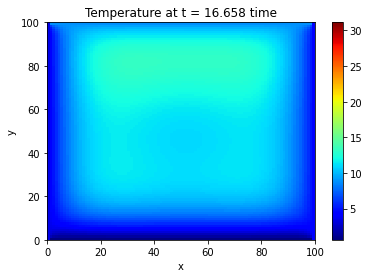

In [10]:
plot(0, np.amin(u), np.amax(u) + 10)
plt.show()
plot(max_iter_time // 2, np.amin(u), np.amax(u) + 10)
plt.show()
plot(max_iter_time-1, np.amin(u), np.amax(u) + 10)
plt.show()

### 3-Dimensional heat equation
For 3-dimensions, we add another spatial variable:

> $u_t = k(u_{xx} + u_{yy} + u_{zz})$

This allows us to adapt our finite difference scheme from before:

>$u_{i,j,k}^{l+1} - k(\frac{u^{l}_{i+1,j,k} - 2u^k_{i,j,k} + u^k_{i-1,j,k}}{\Delta x^2} + \frac{u^{l}_{i,j+1,k} - 2u^l_{i,j,k} + u^k_{i,j-1,k}}{\Delta y^2} + \frac{u^l_{i,j,k+1} -2u^l_{i,j,k} + u^l_{i,j,k-1}}{\Delta z^2}) = 0$


Which we can rewrite as follows, if we assume $\Delta x = \Delta y = \Delta z$:

>  $u_{i,j,k}^{l+1} = \gamma(u^{l}_{i+1,j,k} + u^l_{i-1,j,k} + u^l_{i,j+1,k}+ u^l_{i,j-1,k} + u^l_{i,j,k+1} + u^l_{i,j,k-1} - 6u^l_{i,j,k}) + u^l_{i,j,k}$

where

> $\gamma =  k \frac{\Delta t}{\Delta x^2}$

This is stable under the CFL Conditions

> $\Delta t \leq \frac{\Delta x^2}{6k}$



In [11]:
def finite_difference_3d(u):
    for l in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                for k in range(1, plate_length-1, delta_x):
                    u[l+1, i, j, k] = gamma * (u[l][i+1][j][k] + u[l][i-1][j][k] + u[l][i][j+1][k] + u[l][i][j-1][k] + u[l][i][j][k+1] + u[l][i][j][k-1]- 6*u[l][i][j][k]) + u[l][i][j][k]
    return u

In [12]:
plate_length = 20
max_iter_time = 500

alpha = 4.5 # conductive constant of materials
delta_x = 1

delta_t = (delta_x **2) / (6*alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

u = np.empty((max_iter_time, plate_length, plate_length, plate_length))
# initial conditions
u_initial = 60

u_top = 70
u_bottom = 50
u_m1 = 61
u_m2 = 60
u_m3 = 60
u_m4 = 60

u.fill(u_initial)

u[:][1:-1,1:-1,-1] = u_top
u[:][1:-1,1:-1,0] = u_bottom
u[:][1:-1,0,1:-1] = u_m1
u[:][1:-1,-1,1:-1] = u_m2
u[:][0,1:-1,1:-1] = u_m3
u[:][-1,1:-1,1:-1] = u_m4


In [13]:
u = finite_difference_3d(u)

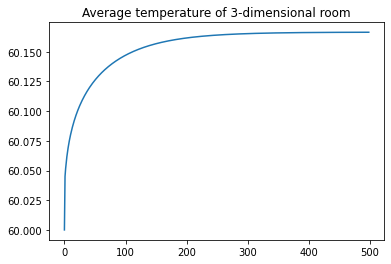

In [14]:
plt.ion()
plt.clf()
aves = []
for i in range(u.shape[0]):
    aves.append(np.mean(u[i], axis=None))
plt.plot([i for i in range(u.shape[0]-1)], aves[:-1])
plt.title('Average temperature of 3-dimensional room')
plt.show()
plt.ioff()

### Modeling multiple rooms at once.

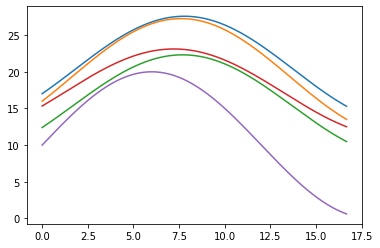

In [15]:
k1 = 1/10
k2 = 1/5
k3 = 2/5
k4 = 1/2
thermal_floor = [k1, 0, 1/10, k1]

thermal_internal_walls = [[0,k2, k2, 0], [k2,0, 0, k2], [k2, 0, 0, k2], [0, 0, 0, k2]]

thermal_external_walls = [k3, k4, k3, k4]

Tg = 0

Te_const = 10
Te_sin_coef = 10

T0 = [5, 10, 15, 20]

f = [5, 2.5, 0, 5]

T = two_body_house_solution(thermal_floor, thermal_internal_walls, thermal_external_walls,Te_const,Te_sin_coef,Tg,T0,f)

Tg = lambda t: Te_const + Te_sin_coef*np.sin(np.pi/12*t) 
plate_length = 100
max_iter_time = 2000

alpha = 30 # thermal diffusivity constant of material
delta_x = 1

delta_t = (delta_x **2) / (4*alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)
times = np.linspace(0, delta_t * max_iter_time, max_iter_time)

boundaries = T(times)
for i in range(4):
    plt.plot(times, boundaries[:,i])
plt.plot(times, Tg(times))
plt.show()

outside = Tg(times)
room1 = boundaries[:,0]
room2 = boundaries[:,1]
room3 = boundaries[:,2]
room4 = boundaries[:,3]



Creating first room...
Creating second room...
Creating third room...
Creating fourth room...
Creating animation...


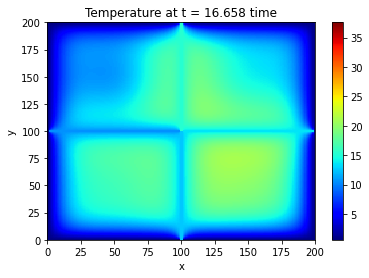

In [16]:
u1 = np.empty((max_iter_time, plate_length, plate_length))
# initial conditions
u_initial = 5

u1.fill(u_initial)

u1[:,(plate_length-1):,:] = outside[0] # top
u1[:,:,:1] = outside[0] # left
u1[:,:1,1:] = room3[0] # bottom
u1[:,:,(plate_length-1):] = room1[0] # right


u2 = np.empty((max_iter_time, plate_length, plate_length))
# initial conditions
u_initial = 10

u2.fill(u_initial)

u2[:,(plate_length-1):,:] = outside[0] # top
u2[:,:,:1] = room1[0] # left
u2[:,:1,1:] = room2[0] # bottom
u2[:,:,(plate_length-1):] = outside[0] # right

u3 = np.empty((max_iter_time, plate_length, plate_length))
# initial conditions
u_initial = 15

u3.fill(u_initial)

u3[:,(plate_length-1):,:] = room3[0] # top
u3[:,:,:1] = outside[0] # left
u3[:,:1,1:] = outside[0] # bottom
u3[:,:,(plate_length-1):] = room4[0] # right
u4 = np.empty((max_iter_time, plate_length, plate_length))
# initial conditions
u_initial = 20

u4.fill(u_initial)

u4[:,(plate_length-1):,:] = room2[0] # top
u4[:,:,:1] = room4[0] # left
u4[:,:1,1:] = outside[0] # bottom
u4[:,:,(plate_length-1):] = outside[0] # right

print('Creating first room...')
u1 = finite_difference_var(u1, outside, outside, room1, room3) # top left right bottom
print('Creating second room...')
u2 = finite_difference_var(u2, outside, room1, outside, room2)
print('Creating third room...')
u3 = finite_difference_var(u3, room3, outside, room4, outside)
print('Creating fourth room...')
u4 = finite_difference_var(u4, room2, room4, outside, outside)

u = np.empty((u1.shape[0], u1.shape[1] * 2, u1.shape[2] * 2))
u[:, u1.shape[1]:, :u1.shape[2]] = u1
u[:, u2.shape[1]:, u1.shape[2]:] = u2
u[:, :u3.shape[1], :u3.shape[2]] = u3
u[:, :u4.shape[1], u4.shape[2]:] = u4
print('Creating animation...')
anim = ani.FuncAnimation(plt.figure(), plot, interval=2, frames=max_iter_time, repeat=False, fargs=(np.amin(u), np.amax(u) + 10))
anim.save('heat_flow.mp4')
HTML(anim.to_html5_video())

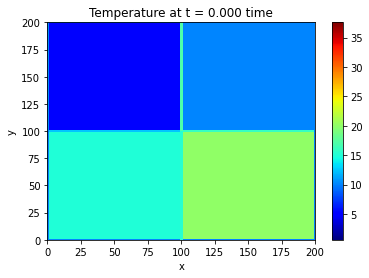

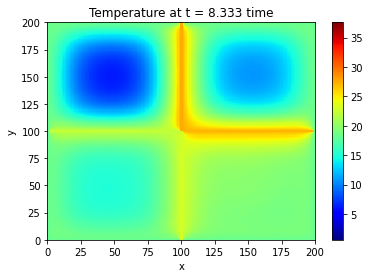

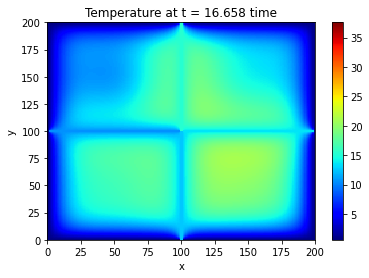

In [17]:
plot(0, np.amin(u), np.amax(u) + 10)
plt.show()
plot(max_iter_time // 2, np.amin(u), np.amax(u) + 10)
plt.show()
plot(max_iter_time-1, np.amin(u), np.amax(u) + 10)
plt.show()